# Fieldvision

## Imports

In [ ]:
from fieldvision_complete import *
from evaluation_pipeline import *

import numpy as np
import matplotlib.pyplot as plt

from fieldvision_complete import (
    make_multi_drone_env,
    MAPPOWrapper,
    get_difficulty_config,
    run_comparison_experiment,
)

from evaluation_pipeline import (
    save_comprehensive_checkpoint,
    print_results_summary,
    evaluate_all_baselines,
    generate_all_figures,
    save_checkpoint,
    get_all_policies,
    print_checklist,
    # New comprehensive evaluation
    run_multi_scenario_evaluation,
    run_generalization_test,
    save_comprehensive_results,
    print_multi_scenario_summary,
    print_generalization_summary,
    GENERALIZATION_SCENARIOS,
    ALL_SCENARIOS,
)


## Configuration

In [ ]:
# Primary scenario for detailed analysis
DIFFICULTY = "network_aware"  # Options: easy, medium, hard, streaming_hard, stress,
                              #          rural_field, variable_terrain, weather_stress,
                              #          peak_survey, network_aware

# Evaluation settings
N_EPISODES = 30               # Episodes for baseline evaluation
TOTAL_TIMESTEPS = 200_000     # Training timesteps for MARL
N_SEEDS = 5                   # Seeds for MARL comparison
SEED = 42

# Multi-scenario settings
EVAL_SCENARIOS = ["hard", "rural_field", "variable_terrain", "network_aware", "peak_survey"]
N_EPISODES_PER_SCENARIO = 20

print("=" * 60)
print("FieldVision MARL Experiment")
print("=" * 60)
print(f"Primary Scenario: {DIFFICULTY}")
print(f"Baseline episodes: {N_EPISODES}")
print(f"MARL timesteps: {TOTAL_TIMESTEPS:,}")
print(f"MARL seeds: {N_SEEDS}")
print(f"\nMulti-scenario evaluation: {EVAL_SCENARIOS}")

config = get_difficulty_config(DIFFICULTY)
print("\nPrimary Environment Config:")
for k, v in config.items():
    print(f"  {k}: {v}")

FieldVision MARL Experiment
Primary Scenario: network_aware
Baseline episodes: 30
MARL timesteps: 200,000
MARL seeds: 5

Multi-scenario evaluation: ['hard', 'rural_field', 'variable_terrain', 'network_aware', 'peak_survey']

Primary Environment Config:
  chunks_per_drone: [12, 12, 12, 12]
  chunk_size_mb: 14.0
  base_deadline: 20
  base_baseline: 5.0
  base_amplitude: 4.0
  base_wavelength: 12.0
  network_noise_std: 2.0
  max_steps: 300
  streaming_enabled: True
  stream_interval: 3
  workload_band: None


## Baseline Evaluation (Primary Scenario)

In [ ]:
print("\n" + "=" * 60)
print("BASELINE POLICY EVALUATION")
print("=" * 60)

baseline_results = evaluate_all_baselines(
    difficulty=DIFFICULTY,
    n_episodes=N_EPISODES,
    seed=SEED,
    verbose=True
)

# Print summary table
print("\n" + "-" * 60)
print("SUMMARY")
print("-" * 60)
for name, collector in baseline_results.items():
    s = collector.summary()
    print(f"{name:20s}: Reward={s['reward_mean']:7.1f} ± {s['reward_std']:5.1f}  "
          f"L={s['local_pct']:4.0f}% E={s['edge_pct']:4.0f}% C={s['cloud_pct']:4.0f}%")



BASELINE POLICY EVALUATION
BASELINE EVALUATION - network_aware
Episodes: 30, Seed: 42

Evaluating Local-Only...
  Reward: -6693.2 ± 0.0
  Actions: L=100% E=0% C=0%

Evaluating Edge-Only...
  Reward: -235.4 ± 71.6
  Actions: L=0% E=100% C=0%

Evaluating Cloud-Only...
  Reward: -381.4 ± 60.5
  Actions: L=0% E=0% C=100%

Evaluating Round-Robin...
  Reward: -413.3 ± 53.7
  Actions: L=34% E=33% C=33%

Evaluating Random...
  Reward: -184.5 ± 71.2
  Actions: L=34% E=33% C=33%

Evaluating Multi-Metric...
  Reward: 5.7 ± 61.4
  Actions: L=51% E=48% C=0%

Evaluating Multi-Metric-BW...
  Reward: -84.7 ± 58.9
  Actions: L=37% E=63% C=0%

Evaluating Multi-Metric-Urgent...
  Reward: 1.0 ± 58.0
  Actions: L=52% E=46% C=2%

Evaluating Latency-Greedy...
  Reward: -381.4 ± 60.5
  Actions: L=0% E=0% C=100%

------------------------------------------------------------
SUMMARY
------------------------------------------------------------
Local-Only          : Reward=-6693.2 ±   0.0  L= 100% E=   0% C=   0%

## Multi-Scenario Baseline Evaluation

In [ ]:
print("\n" + "=" * 60)
print("MULTI-SCENARIO BASELINE EVALUATION")
print("=" * 60)

policies = get_all_policies(seed=SEED)

# Run comprehensive evaluation across scenarios
multi_scenario_results = run_multi_scenario_evaluation(
    policies=policies,
    scenarios=EVAL_SCENARIOS,
    n_episodes=N_EPISODES_PER_SCENARIO,
    seed=SEED,
    comprehensive=True,  # Saves per-step data!
    verbose=True
)

# Print summary
print_multi_scenario_summary(multi_scenario_results)


MULTI-SCENARIO BASELINE EVALUATION

Scenario: hard
  Evaluating Local-Only... Reward=-6527.2±0.0
  Evaluating Edge-Only... Reward=311.6±81.5
  Evaluating Cloud-Only... Reward=91.1±72.3
  Evaluating Round-Robin... Reward=-41.0±75.8
  Evaluating Random... Reward=193.8±63.4
  Evaluating Multi-Metric... Reward=358.2±78.0
  Evaluating Multi-Metric-BW... Reward=323.0±76.0
  Evaluating Multi-Metric-Urgent... Reward=362.3±78.1
  Evaluating Latency-Greedy... Reward=91.1±72.3

Scenario: rural_field
  Evaluating Local-Only... Reward=-5057.3±0.0
  Evaluating Edge-Only... Reward=232.2±94.5
  Evaluating Cloud-Only... Reward=51.1±84.9
  Evaluating Round-Robin... Reward=137.6±68.0
  Evaluating Random... Reward=147.0±69.8
  Evaluating Multi-Metric... Reward=327.0±79.4
  Evaluating Multi-Metric-BW... Reward=246.1±82.4
  Evaluating Multi-Metric-Urgent... Reward=317.1±76.0
  Evaluating Latency-Greedy... Reward=51.1±84.9

Scenario: variable_terrain
  Evaluating Local-Only... Reward=-6467.2±0.0
  Evaluatin

## MARL Training (Primary Scenario)

In [ ]:
print("\n" + "=" * 60)
print("TRAINING MARL AGENTS")
print("=" * 60)

marl_results = run_comparison_experiment(
    total_timesteps=TOTAL_TIMESTEPS,
    n_seeds=N_SEEDS,
    difficulty=DIFFICULTY,
)

# Print MARL results
print("\n" + "-" * 60)
print("MARL RESULTS SUMMARY")
print("-" * 60)
for alg, stats in marl_results.items():
    print(f"  {alg}: {stats['reward_mean']:.2f} ± {stats['reward_std']:.2f} "
          f"(Comp={stats['completion']:.1f}% L={stats['local_pct']:.0f}% E={stats['edge_pct']:.0f}% C={stats['cloud_pct']:.0f}%)")



TRAINING MARL AGENTS

Training SINGLE_AGENT_PPO

--- Seed 1/5 ---
Update 10/195 | Steps: 10,240 | Reward: 38.37 | A_Loss: -0.2353 | C_Loss: 426.1874 | Ent: 0.434
Update 20/195 | Steps: 20,480 | Reward: 101.93 | A_Loss: -0.0965 | C_Loss: 325.8867 | Ent: 0.268
Update 30/195 | Steps: 30,720 | Reward: 112.46 | A_Loss: -0.1227 | C_Loss: 266.6716 | Ent: 0.207
Update 40/195 | Steps: 40,960 | Reward: 121.20 | A_Loss: -0.1174 | C_Loss: 288.3194 | Ent: 0.214
Update 50/195 | Steps: 51,200 | Reward: 113.75 | A_Loss: -0.1226 | C_Loss: 285.8491 | Ent: 0.221
Update 60/195 | Steps: 61,440 | Reward: 121.42 | A_Loss: -0.1429 | C_Loss: 249.8316 | Ent: 0.230
Update 70/195 | Steps: 71,680 | Reward: 121.43 | A_Loss: -0.1496 | C_Loss: 289.4229 | Ent: 0.209
Update 80/195 | Steps: 81,920 | Reward: 115.13 | A_Loss: -0.1722 | C_Loss: 315.8741 | Ent: 0.122
Update 90/195 | Steps: 92,160 | Reward: 112.86 | A_Loss: -0.1611 | C_Loss: 275.2060 | Ent: 0.107
Update 100/195 | Steps: 102,400 | Reward: 117.25 | A_Loss: -0

## Generalization Scenario

In [ ]:
print("\n" + "=" * 60)
print("GENERALIZATION TEST")
print("=" * 60)

# Train on primary scenario, test on all
gen_results = run_generalization_test(
    train_scenario=DIFFICULTY,
    test_scenarios=EVAL_SCENARIOS,
    total_timesteps=TOTAL_TIMESTEPS,
    n_eval_episodes=N_EPISODES_PER_SCENARIO,
    algorithm="mappo",
    seed=SEED,
    verbose=True
)

print_generalization_summary(gen_results)



GENERALIZATION TEST

Training MAPPO on network_aware
Update 10/195 | Steps: 10,240 | Reward: 7.21 | A_Loss: -0.3358 | C_Loss: 426.9341 | Ent: 0.465
Update 20/195 | Steps: 20,480 | Reward: 105.76 | A_Loss: -0.0955 | C_Loss: 294.1331 | Ent: 0.122
Update 30/195 | Steps: 30,720 | Reward: 108.75 | A_Loss: -0.1213 | C_Loss: 202.9539 | Ent: 0.069
Update 40/195 | Steps: 40,960 | Reward: 118.38 | A_Loss: -0.1185 | C_Loss: 230.9432 | Ent: 0.120
Update 50/195 | Steps: 51,200 | Reward: 115.75 | A_Loss: -0.1146 | C_Loss: 222.1182 | Ent: 0.137
Update 60/195 | Steps: 61,440 | Reward: 117.58 | A_Loss: -0.1344 | C_Loss: 234.7782 | Ent: 0.128
Update 70/195 | Steps: 71,680 | Reward: 120.71 | A_Loss: -0.1260 | C_Loss: 266.9596 | Ent: 0.098
Update 80/195 | Steps: 81,920 | Reward: 110.47 | A_Loss: -0.1363 | C_Loss: 202.3622 | Ent: 0.077
Update 90/195 | Steps: 92,160 | Reward: 110.31 | A_Loss: -0.1380 | C_Loss: 203.0082 | Ent: 0.105
Update 100/195 | Steps: 102,400 | Reward: 118.51 | A_Loss: -0.1197 | C_Loss

In [ ]:
save_comprehensive_checkpoint(
    "ijcnn_results",
    marl_results,
    baseline_results=baseline_results,
    config={
        'difficulty': 'streaming_hard',
        'total_timesteps': 200_000,
        'n_seeds': 3,
    }
)


✓ Saved summary table to ijcnn_results/summary_table.csv
✓ Saved LaTeX table to ijcnn_results/summary_table.tex
✓ Generated figures in ijcnn_results/figures/
  - reward_comparison.png
  - completion_comparison.png
  - ontime_comparison.png
  - latency_comparison.png
  - battery_comparison.png
  - action_distribution.png
  - multi_metric_comparison.png

COMPREHENSIVE RESULTS SUMMARY

Algorithm                     Reward    Comp%  OnTime%    Latency   Battery% Actions (L/E/C)
-----------------------------------------------------------------------------------------------

[BASELINES]
Local-Only               -6693.2±0.0    83.3%    83.3%       1.2      92.0% 100/0/0
Edge-Only                -235.4±71.6    21.7%    21.7%      19.9       0.0% 0/100/0
Cloud-Only               -381.4±60.5    21.7%    21.7%      19.9       0.0% 0/0/100
Round-Robin              -413.3±53.7    55.3%    55.3%       4.1      51.1% 34/33/33
Random                   -184.5±71.2    50.3%    50.3%       5.7      45.3%

,Algorithm,Type,Reward,Completion %,On-Time %,Deadline Misses,Avg Latency,Battery Used %,Local %,Edge %,Cloud %
0,Local-Only,Baseline,-6693.2 ± 0.0,83.3,83.3,4.00,1.2,92.0,100,0,0
1,Edge-Only,Baseline,-235.4 ± 71.6,21.7,21.7,4.00,19.9,0.0,0,100,0
2,Cloud-Only,Baseline,-381.4 ± 60.5,21.7,21.7,4.00,19.9,0.0,0,0,100
3,Round-Robin,Baseline,-413.3 ± 53.7,55.3,55.3,4.00,4.1,51.1,34,33,33
4,Random,Baseline,-184.5 ± 71.2,50.3,50.3,4.00,5.7,45.3,34,33,33
5,Multi-Metric,Baseline,5.7 ± 61.4,59.3,59.3,4.00,3.4,47.5,51,48,0
6,Multi-Metric-BW,Baseline,-84.7 ± 58.9,48.4,48.4,4.00,4.9,36.8,37,63,0
7,Multi-Metric-Urgent,Baseline,1.0 ± 58.0,59.9,59.9,4.00,3.3,48.1,52,46,2
8,Latency-Greedy,Baseline,-381.4 ± 60.5,21.7,21.7,4.00,19.9,0.0,0,0,100
9,single_agent_ppo,MARL,130.3 ± 63.3,66.6,66.6,4.00,3.0,52.6,55,45,0


## Generate Figures

In [ ]:
# print("\n" + "=" * 60)
# print("GENERATING FIGURES")
# print("=" * 60)

# # Generate figures with MARL results included, excluding Local-Only outlier
# summary_df = generate_all_figures(
#     results=baseline_results,
#     output_dir="figures/",
#     marl_results=marl_results,
#     exclude_outliers=True,
#     outlier_policies=["Local-Only"]
# )

# print("\n" + "-" * 60)
# print("COMBINED SUMMARY TABLE (sorted by reward)")
# print("-" * 60)
# print(summary_df[['policy', 'reward_mean', 'reward_std', 'completion', 'local_pct', 'edge_pct', 'cloud_pct']].to_string(index=False))



## Save Comprehensive Results

In [ ]:
# print("\n" + "=" * 60)
# print("SAVING COMPREHENSIVE RESULTS")
# print("=" * 60)

# experiment_config = {
#     "difficulty": DIFFICULTY,
#     "n_episodes": N_EPISODES,
#     "total_timesteps": TOTAL_TIMESTEPS,
#     "n_seeds": N_SEEDS,
#     "seed": SEED,
#     "eval_scenarios": EVAL_SCENARIOS,
#     "n_episodes_per_scenario": N_EPISODES_PER_SCENARIO,
#     **config,
# }

# # Save basic checkpoint
# checkpoint_df = save_checkpoint(
#     output_dir="./experiment_results",
#     results=baseline_results,
#     config=experiment_config,
#     marl_results=marl_results,
# )

# # Save comprehensive results with per-step data
# save_comprehensive_results(
#     output_dir="./experiment_results/comprehensive",
#     multi_scenario_results=multi_scenario_results,
#     generalization_results=gen_results,
#     config=experiment_config,
# )

# # Print final leaderboard
# print("\n" + "=" * 60)
# print("FINAL LEADERBOARD")
# print("=" * 60)
# print(checkpoint_df[['policy', 'reward_mean', 'reward_std', 'completion']].head(10).to_string(index=False))

# # Highlight best performers
# best_baseline = None
# best_marl = None
# marl_algs = ['single_agent_ppo', 'centralized_ppo', 'mappo']
# for _, row in checkpoint_df.iterrows():
#     policy = row['policy']
#     if policy in marl_algs:
#         if best_marl is None:
#             best_marl = (policy, row['reward_mean'])
#     elif policy != 'Local-Only':
#         if best_baseline is None:
#             best_baseline = (policy, row['reward_mean'])

# if best_baseline and best_marl:
#     print(f"\nBest Baseline: {best_baseline[0]} ({best_baseline[1]:.1f})")
#     print(f"Best MARL:     {best_marl[0]} ({best_marl[1]:.1f})")
#     diff = best_marl[1] - best_baseline[1]
#     print(f"MARL vs Best Baseline: {diff:+.1f} ({diff/abs(best_baseline[1])*100:+.1f}%)")

# # Compare MAPPO (cooperative) vs Single-Agent PPO (uncoordinated)
# mappo_stats = marl_results.get('mappo', {})
# single_stats = marl_results.get('single_agent_ppo', {})
# if mappo_stats and single_stats:
#     mappo_r = mappo_stats.get('reward_mean', 0)
#     single_r = single_stats.get('reward_mean', 0)
#     print(f"\nCooperative Learning Benefit:")
#     print(f"  MAPPO: {mappo_r:.1f}")
#     print(f"  Single-Agent PPO: {single_r:.1f}")
#     print(f"  Coordination gain: {mappo_r - single_r:+.1f} ({(mappo_r - single_r)/abs(single_r)*100:+.1f}%)")



## Download Results

In [ ]:
!zip -r ijcnn_results.zip ijcnn_results/
from google.colab import files
files.download('ijcnn_results.zip')

  adding: ijcnn_results/ (stored 0%)
  adding: ijcnn_results/marl/ (stored 0%)
  adding: ijcnn_results/marl/mappo/ (stored 0%)
  adding: ijcnn_results/marl/mappo/episode_metrics.csv (deflated 71%)
  adding: ijcnn_results/marl/mappo/summary.json (deflated 55%)
  adding: ijcnn_results/marl/single_agent_ppo/ (stored 0%)
  adding: ijcnn_results/marl/single_agent_ppo/episode_metrics.csv (deflated 72%)
  adding: ijcnn_results/marl/single_agent_ppo/summary.json (deflated 54%)
  adding: ijcnn_results/marl/centralized_ppo/ (stored 0%)
  adding: ijcnn_results/marl/centralized_ppo/episode_metrics.csv (deflated 69%)
  adding: ijcnn_results/marl/centralized_ppo/summary.json (deflated 54%)
  adding: ijcnn_results/config.json (deflated 11%)
  adding: ijcnn_results/baselines/ (stored 0%)
  adding: ijcnn_results/baselines/Cloud_Only/ (stored 0%)
  adding: ijcnn_results/baselines/Cloud_Only/episode_metrics.csv (deflated 72%)
  adding: ijcnn_results/baselines/Random/ (stored 0%)
  adding: ijcnn_results/b

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2019102872.py:171: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


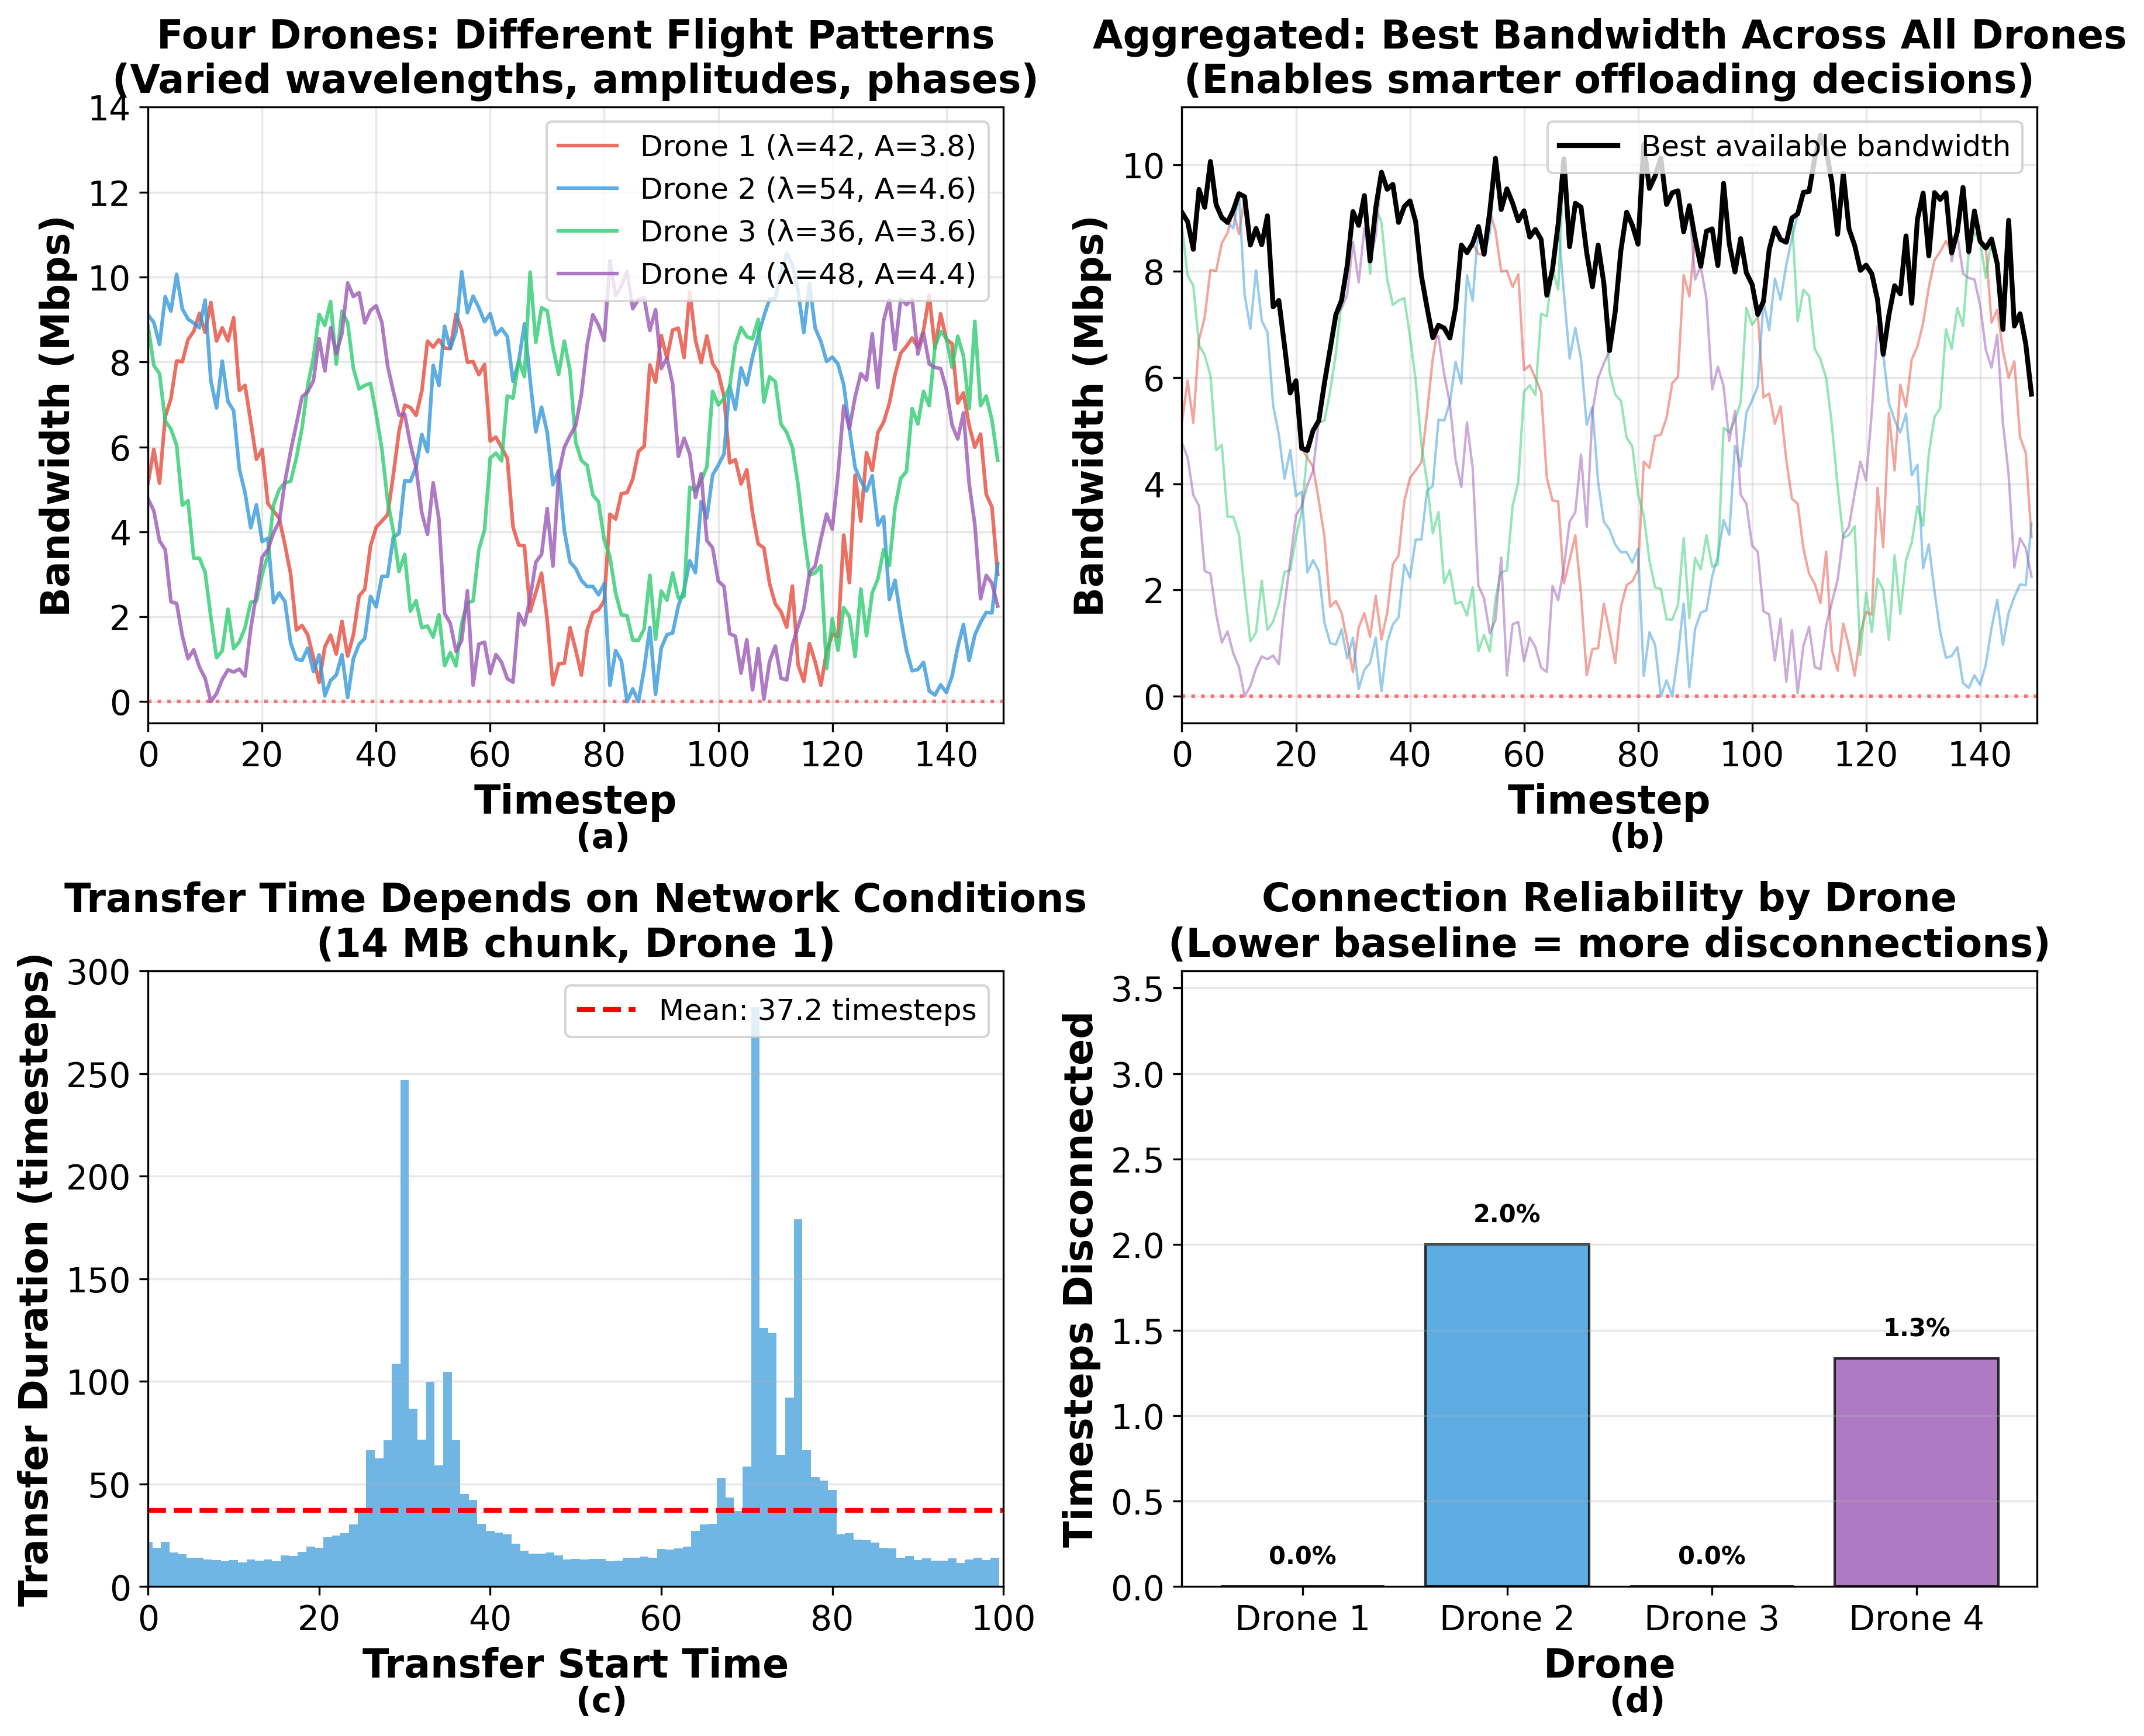


Scenario: network_aware
Config: baseline=5.0 Mbps, amplitude=4.0, wavelength=12.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fieldvision_complete import get_difficulty_config, SinusoidalNetProvider

# Get network_aware scenario config
config = get_difficulty_config('network_aware')

# Create network providers for each drone with different parameters
np.random.seed(42)
n_timesteps = 150
n_drones = 4

# Base parameters from config
base_wavelength = config.get('base_wavelength', 12)
base_amplitude = config.get('base_amplitude', 4.0)
base_baseline = config.get('base_baseline', 5.0)
noise_std = config.get('network_noise_std', 2.0)

# Create providers with varied parameters (like the scenario does)
# Use lower noise for cleaner visualization
visual_noise_std = min(noise_std, 0.5)

providers = []
drone_params = []
wavelength_multipliers = [3.5, 4.5, 3.0, 4.0]  # Different wavelengths
amplitude_multipliers = [0.95, 1.15, 0.9, 1.1]
phases = [0, np.pi/3, 2*np.pi/3, np.pi]

for i in range(n_drones):
    wavelength = base_wavelength * wavelength_multipliers[i]
    amplitude = base_amplitude * amplitude_multipliers[i]
    phase = phases[i]

    provider = SinusoidalNetProvider(
        wavelength=wavelength,
        amplitude=amplitude,
        baseline=base_baseline,
        noise_std=visual_noise_std,
        phase=phase,
        seed=42 + i
    )
    providers.append(provider)
    drone_params.append({'wavelength': wavelength, 'amplitude': amplitude})

# Collect bandwidth data for all drones
all_bandwidths = []
all_connected = []

for drone_idx, provider in enumerate(providers):
    bws = []
    conns = []
    for t in range(n_timesteps):
        state = provider.next()
        bws.append(state['drone_ground_bandwidth_mbps'])
        conns.append(state['drone_ground_connected'])
    all_bandwidths.append(bws)
    all_connected.append(conns)

all_bandwidths = np.array(all_bandwidths)
all_connected = np.array(all_connected)

# Calculate transfer times for different start times
chunk_size_mb = config.get('chunk_size_mb', 14.0)
transfer_times = []
start_times = list(range(0, 100))

for start_t in start_times:
    # Use drone 0's bandwidth
    bw = all_bandwidths[0, start_t] if start_t < n_timesteps else 0.1
    if bw > 0.1:
        # Transfer time = chunk_size * 8 bits / bandwidth Mbps
        duration = chunk_size_mb * 8 / bw
    else:
        duration = 200  # Very long if disconnected
    transfer_times.append(duration)

# Create figure with 4 subplots (2x2)
fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 10),
    dpi=300,
    constrained_layout=True
)

# --- Panel 1: Four Drones Different Flight Patterns ---
ax1 = axes[0, 0]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
for i in range(n_drones):
    label = f"Drone {i+1} (λ={drone_params[i]['wavelength']:.0f}, A={drone_params[i]['amplitude']:.1f})"
    ax1.plot(range(n_timesteps), all_bandwidths[i], color=colors[i], alpha=0.8, linewidth=1.5, label=label)

ax1.axhline(y=0, color='red', linestyle=':', alpha=0.5)
ax1.set_xlabel('Timestep', fontsize=16, fontweight='bold')
ax1.set_ylabel('Bandwidth (Mbps)', fontsize=16, fontweight='bold')
ax1.set_title('Four Drones: Different Flight Patterns\n(Varied wavelengths, amplitudes, phases)', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right', fontsize=12)
ax1.set_xlim(0, n_timesteps)
ax1.set_ylim(0, 14)
ax1.set_ylim(bottom=-0.5)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=14)
ax1.text(0.5, -0.16, '(a)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top')

# --- Panel 2: Aggregated Best Bandwidth ---
ax2 = axes[0, 1]
best_bandwidth = np.max(all_bandwidths, axis=0)

# Plot individual drones faded in background
for i in range(n_drones):
    ax2.plot(range(n_timesteps), all_bandwidths[i], color=colors[i], alpha=0.5, linewidth=1)

# Plot best bandwidth as thick black line
ax2.plot(range(n_timesteps), best_bandwidth, color='black', linewidth=2, label='Best available bandwidth')
ax2.axhline(y=0, color='red', linestyle=':', alpha=0.5)

ax2.set_xlabel('Timestep', fontsize=16, fontweight='bold')
ax2.set_ylabel('Bandwidth (Mbps)', fontsize=16, fontweight='bold')
ax2.set_title('Aggregated: Best Bandwidth Across All Drones\n(Enables smarter offloading decisions)', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', fontsize=12)
ax2.set_xlim(0, n_timesteps)
ax2.set_ylim(bottom=-0.5)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=14)
ax2.text(0.5, -0.16, '(b)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top')


# --- Panel 3: Transfer Time vs Start Time ---
ax3 = axes[1, 0]
ax3.bar(start_times, transfer_times, width=1.0, color='#3498db', alpha=0.7)
mean_transfer = np.mean(transfer_times)
ax3.axhline(y=mean_transfer, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_transfer:.1f} timesteps')

ax3.set_xlabel('Transfer Start Time', fontsize=16, fontweight='bold')
ax3.set_ylabel('Transfer Duration (timesteps)', fontsize=16, fontweight='bold')
ax3.set_title(f'Transfer Time Depends on Network Conditions\n({chunk_size_mb:.0f} MB chunk, Drone 1)', fontsize=16, fontweight='bold')
ax3.legend(loc='upper right', fontsize=12)
ax3.set_xlim(0, 100)
ax3.set_ylim(0, 300)
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='both', labelsize=14)
ax3.text(0.5, -0.16, '(c)', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top')


# --- Panel 4: Connection Reliability by Drone ---
ax4 = axes[1, 1]
disconnection_pcts = []
for i in range(n_drones):
    disconnected = sum(1 for c in all_connected[i] if not c)
    pct = disconnected / n_timesteps * 100
    disconnection_pcts.append(pct)

drone_labels = [f'Drone {i+1}' for i in range(n_drones)]
bars = ax4.bar(drone_labels, disconnection_pcts, color=['#3498db', '#3498db', '#3498db', '#9b59b6'],
               alpha=0.8, edgecolor='black')

# Add percentage labels on bars
for bar, pct in zip(bars, disconnection_pcts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.set_xlabel('Drone', fontsize=16, fontweight='bold')
ax4.set_ylabel('Timesteps Disconnected', fontsize=16, fontweight='bold')
ax4.set_title('Connection Reliability by Drone\n(Lower baseline = more disconnections)', fontsize=16, fontweight='bold')
ax4.set_ylim(0, max(max(disconnection_pcts) * 1.3, 1) + 1)
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='both', labelsize=14)
ax4.text(0.5, -0.16, '(d)', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top')


plt.tight_layout()
plt.savefig('network_aware_demo.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nScenario: network_aware")
print(f"Config: baseline={base_baseline} Mbps, amplitude={base_amplitude}, wavelength={base_wavelength}")